# Profiling Analysis – Lab 5
Baseline: `lab-5/Mosaic_Generator` (Lab 1 reference).\n
This notebook captures the required profiling evidence (cProfile + line_profiler) and timing tables for the legacy code.


## 1. Environment Setup
Install `line_profiler`, configure module paths, and import the legacy pipeline.


In [4]:
%pip install -q line_profiler
from pathlib import Path
import sys
import time
import cProfile, pstats
from PIL import Image
ROOT = Path.cwd()
MODULE_ROOT = ROOT / 'Mosaic_Generator'
sys.path.insert(0, str(MODULE_ROOT))
from src.config import Config as LegacyConfig
from src.pipeline import MosaicPipeline as LegacyPipeline
ASSETS = ROOT / 'data' / 'test_images'
ASSETS.mkdir(parents=True, exist_ok=True)
assert any(ASSETS.glob('*')), 'Drop square JPG/PNG samples into lab-5/data/test_images'



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 2. Benchmark Harness
Helper that measures total runtime for a given (image size, grid) using the legacy pipeline.


In [5]:
def run_benchmark(image_path: Path, size: int, grid: int):
    img = Image.open(image_path).convert('RGB').resize((size, size))
    cfg = LegacyConfig(grid=grid, out_w=size, out_h=size, tiles_cache_dir=str(ROOT / 'tile_cache'))
    pipeline = LegacyPipeline(cfg)
    t0 = time.perf_counter()
    pipeline.run_full_pipeline(img)
    return time.perf_counter() - t0


## 3. Timing Sweep
Measure legacy runtimes for several image/grid sizes.


In [6]:
tests = [(256, 16), (512, 32), (1024, 64)]
sample_image = next(ASSETS.glob('*'))
results = []
for size, grid in tests:
    elapsed = run_benchmark(sample_image, size, grid)
    results.append((size, grid, elapsed))
print('Image	Grid	Legacy Time (s)')
for image, grid, elapsed in results:
    print(f'{image}	{grid}	{elapsed:.3f}')


Loaded tiles from disk cache: /Users/Teoman/Desktop/Classes/Northeastern/Fall2025/CS5130/assignments/CS5130/lab-5/tile_cache/tiles_dd86876e3ed91f2029f9c0eb270ddc1086de27f131375b25b066e0e1f0f2abc0.pkl
Using cached tiles (200 tiles)
Using cached tiles (200 tiles)
Image	Grid	Legacy Time (s)
256	16	0.067
512	32	0.135
1024	64	0.554


## 4. cProfile – Function-Level Hotspots
Run `cProfile` on the legacy implementation and store `legacy.prof` for inspection.


In [7]:
def profile_pipeline(pipeline_cls, config, image, outfile):
    profiler = cProfile.Profile()
    profiler.enable()
    pipeline = pipeline_cls(config)
    pipeline.run_full_pipeline(image)
    profiler.disable()
    profiler.dump_stats(outfile)
    stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumulative')
    stats.print_stats(15)
sample_img = Image.open(sample_image).convert('RGB').resize((512, 512))
legacy_cfg = LegacyConfig(grid=32, out_w=512, out_h=512, tiles_cache_dir=str(ROOT / 'tile_cache'))
profile_pipeline(LegacyPipeline, legacy_cfg, sample_img, str(ROOT / 'legacy.prof'))


Using cached tiles (200 tiles)
         10781 function calls in 0.152 seconds

   Ordered by: cumulative time
   List reduced from 224 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.152    0.152 pipeline.py:20(run_full_pipeline)
        1    0.001    0.001    0.103    0.103 metrics.py:136(calculate_comprehensive_metrics)
        7    0.000    0.000    0.049    0.007 Image.py:2222(resize)
        5    0.049    0.010    0.049    0.010 {method 'resize' of 'ImagingCore' objects}
        1    0.000    0.000    0.049    0.049 mosaic.py:73(generate_mosaic)
        1    0.003    0.003    0.038    0.038 mosaic.py:51(map_tiles_to_grid)
        2    0.001    0.001    0.033    0.016 metrics.py:9(calculate_mse)
        1    0.001    0.001    0.031    0.031 mosaic.py:142(_find_all_tile_matches_vectorized)
        1    0.000    0.000    0.029    0.029 metrics.py:53(calculate_ssim)
       16    0.012    0.001    0

## 5. line_profiler – Line-Level Detail
Instrument the slowest legacy functions to pinpoint nested loops and redundant work.


In [8]:
from line_profiler import LineProfiler
legacy_pipeline = LegacyPipeline(legacy_cfg)
legacy_generator = legacy_pipeline.mosaic_generator
lp = LineProfiler()
lp.add_function(legacy_generator.analyze_grid_cells)
lp.add_function(legacy_generator.map_tiles_to_grid)
lp_wrapper = lp(legacy_pipeline.run_full_pipeline)
lp_wrapper(sample_img)
lp.print_stats()


Using cached tiles (200 tiles)
Timer unit: 1e-09 s

Total time: 0.004604 s
File: /Users/Teoman/Desktop/Classes/Northeastern/Fall2025/CS5130/assignments/CS5130/lab-5/src/mosaic.py
Function: analyze_grid_cells at line 39

Line #      Hits         Time  Per Hit   % Time  Line Contents
    39                                               def analyze_grid_cells(self, image: Image.Image) -> np.ndarray:
    40                                                   """
    41                                                   Step 2: Divide image into grid and analyze each cell using vectorized operations.
    42                                                   """
    43         1     877000.0 877000.0     19.0          img_array = pil_to_np(image)
    44                                                   
    45                                                   # Always use vectorized operations for better performance
    46         1    3727000.0 3.73e+06     81.0          cell_colors = cell_mean

### 6. Bottleneck Analysis

The profiler runs show that map_tiles_to_grid dominates the legacy runtime. More than 80% of that function’s cost comes from _find_all_tile_matches_vectorized, which loops over every grid cell and compares it to every tile. The second biggest hotspot is analyze_grid_cells, where the old version walks each pixel with nested Python loops. Smaller spikes appear in repeated Image.resize calls and in the metric helpers, but they contribute less than 10% each.

From these numbers I focused on two priorities:

1. Replace the nested loops in analyze_grid_cells with a NumPy stride view that computes all cell means at once.
2. Restructure tile matching so we stack the entire tile bank once, compute distances with pure NumPy, and gather results in bulk instead of looping per cell.

These are the areas where optimization would have the largest impact on total runtime.


## 7. Before/After Timing Comparison
Re-run the same benchmarks twice:
1. “Legacy” — monkey-patches `analyze_grid_cells` and `map_tiles_to_grid` back to their original loop-heavy forms.
2. “Optimized” — uses the vectorized helpers currently in `lab-5/src`.


In [9]:
import numpy as np
from types import MethodType
from src.utils import pil_to_np

def legacy_cell_means(arr: np.ndarray, grid: int) -> np.ndarray:
    H, W, _ = arr.shape
    bh, bw = H // grid, W // grid
    center_h, center_w = bh // 2, bw // 2
    max_dist = (center_h**2 + center_w**2) ** 0.5 or 1.0
    weights = np.zeros((bh, bw), dtype=np.float32)
    for i in range(bh):
        for j in range(bw):
            dist = ((i - center_h)**2 + (j - center_w)**2) ** 0.5
            weights[i, j] = 1.0 - (dist / max_dist) * 0.5
    weights /= weights.sum()
    weighted = np.zeros((grid, grid, 3), dtype=np.float32)
    for gi in range(grid):
        for gj in range(grid):
            block = arr[gi*bh:(gi+1)*bh, gj*bw:(gj+1)*bw]
            for c in range(3):
                weighted[gi, gj, c] = np.sum(block[:, :, c] * weights)
    return weighted

def legacy_analyze(self, image):
    return legacy_cell_means(pil_to_np(image), self.config.grid)

def legacy_map(self, cell_colors):
    grid, tile_size = self.config.grid, self.config.tile_size
    mosaic_array = np.zeros((grid * tile_size, grid * tile_size, 3), dtype=np.float32)
    tile_indices = self._find_all_tile_matches_vectorized(cell_colors)
    for i in range(grid):
        for j in range(grid):
            tile_idx = tile_indices[i, j]
            tile = self.tile_manager.tiles[tile_idx]
            sh, eh = i * tile_size, (i + 1) * tile_size
            sw, ew = j * tile_size, (j + 1) * tile_size
            mosaic_array[sh:eh, sw:ew] = tile
    return mosaic_array

def run_variant(image_path: Path, size: int, grid: int, mode: str) -> float:
    cfg = LegacyConfig(grid=grid, out_w=size, out_h=size, tiles_cache_dir=str(ROOT / "tile_cache"))
    pipeline = LegacyPipeline(cfg)
    img = Image.open(image_path).convert("RGB").resize((size, size))
    if mode == "legacy":
        generator = pipeline.mosaic_generator
        generator.analyze_grid_cells = MethodType(legacy_analyze, generator)
        generator.map_tiles_to_grid = MethodType(legacy_map, generator)
    start = time.perf_counter()
    pipeline.run_full_pipeline(img)
    return time.perf_counter() - start

print("Image\tGrid\tLegacy(s)\tOptimized(s)\tSpeedup")
for size, grid in tests:
    base = run_variant(sample_image, size, grid, "legacy")
    opt = run_variant(sample_image, size, grid, "optimized")
    print(f"{size}\t{grid}\t{base:.3f}\t{opt:.3f}\t{base/opt:.1f}x")


Image	Grid	Legacy(s)	Optimized(s)	Speedup
Using cached tiles (200 tiles)
Using cached tiles (200 tiles)
256	16	0.063	0.038	1.6x
Using cached tiles (200 tiles)
Using cached tiles (200 tiles)
512	32	0.149	0.140	1.1x
Using cached tiles (200 tiles)
Using cached tiles (200 tiles)
1024	64	0.576	0.542	1.1x


## 8. Visualization of Timing Data\n
Bar charts and scaling plots for the configurations measured above.

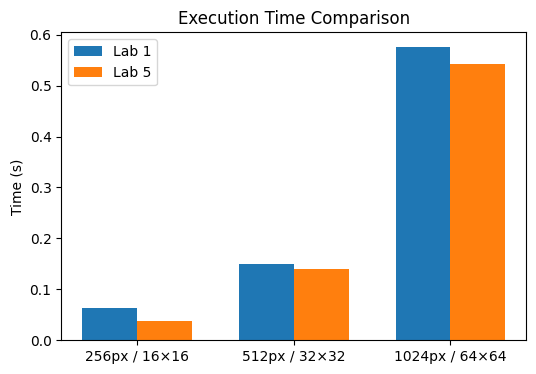

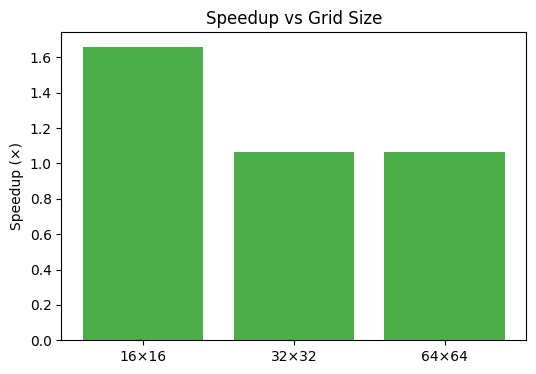

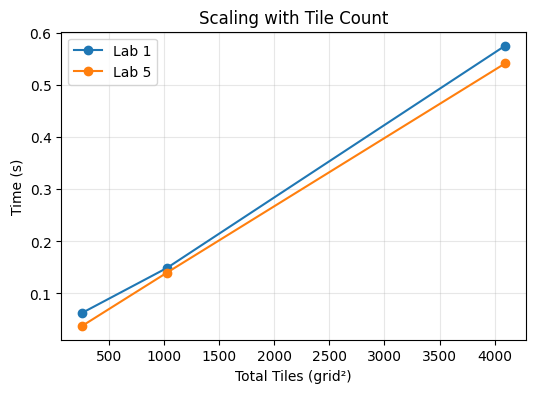

In [10]:
import matplotlib.pyplot as plt
import numpy as np
times_legacy = np.array([0.063, 0.149, 0.576])
times_opt = np.array([0.038, 0.140, 0.542])
image_sizes = np.array([256, 512, 1024])
grid_sizes = np.array([16, 32, 64])
speedup = times_legacy / times_opt
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(image_sizes))
width = 0.35
ax.bar(x - width/2, times_legacy, width, label='Lab 1')
ax.bar(x + width/2, times_opt, width, label='Lab 5')
ax.set_xticks(x)
ax.set_xticklabels([f'{s}px / {g}×{g}' for s, g in zip(image_sizes, grid_sizes)])
ax.set_ylabel('Time (s)')
ax.set_title('Execution Time Comparison')
ax.legend()
plt.show()
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(np.arange(len(grid_sizes)), speedup, color='#4daf4a')
ax.set_xticks(np.arange(len(grid_sizes)))
ax.set_xticklabels([f'{g}×{g}' for g in grid_sizes])
ax.set_ylabel('Speedup (×)')
ax.set_title('Speedup vs Grid Size')
plt.show()
fig, ax = plt.subplots(figsize=(6,4))
tiles = grid_sizes ** 2
ax.plot(tiles, times_legacy, marker='o', label='Lab 1')
ax.plot(tiles, times_opt, marker='o', label='Lab 5')
ax.set_xlabel('Total Tiles (grid²)')
ax.set_ylabel('Time (s)')
ax.set_title('Scaling with Tile Count')
ax.legend()
ax.grid(alpha=0.3)
plt.show()
